# **E9: Detección de Anomalías con LSTM**  

## **Objetivo**  
Implementar un modelo **LSTM** para detectar anomalías en series temporales de consumo energético, asegurando que se ejecute eficientemente sin GPU.

## **Datos de entrada**  
Un dataset con las siguientes columnas:  
- **Consumo Energía (kWh)**  
- **Generación FV (kWh)**  
- **Temperatura (°C)**  
- **Radiación Solar (W/m²)**  

---

# **Pasos a seguir**  

## 1. Cargar y visualizar los datos  

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt

import tensorflow as tf  
from tensorflow.keras.models import Sequential, load_model  
from tensorflow.keras.layers import LSTM, Dense, Dropout  
from sklearn.preprocessing import MinMaxScaler  # Configurar para que use solo CPU  

import os  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Cargar dataset
df = pd.read_csv("data/m4_datos_energia_canarias.csv", usecols=range(1, 6) )

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.set_index('Fecha')
# Ver las primeras filas
print(df.head())

2025-03-17 15:33:59.835860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


            Consumo Energía (kWh)  Generación FV (kWh)  Temperatura (°C)  \
Fecha                                                                      
2023-01-01             259.514697           164.004193         20.477757   
2023-01-02             299.305789           173.408325         18.215363   
2023-01-03             307.509279           170.269137         21.074604   
2023-01-04             316.606347           171.587572         16.938845   
2023-01-05             299.377762           158.578316         22.488135   

            Radiación Solar (W/m²)  
Fecha                               
2023-01-01              496.039170  
2023-01-02              504.088217  
2023-01-03              400.357468  
2023-01-04              546.224484  
2023-01-05              517.902633  


In [2]:
df.describe()

,Consumo Energía (kWh),Generación FV (kWh),Temperatura (°C),Radiación Solar (W/m²)
count,362.000000,360.000000,361.000000,363.000000
mean,286.920289,199.401433,20.226564,604.009230
std,25.891524,25.749239,4.038290,83.308007
min,227.544904,139.773673,10.635462,356.193982
25%,268.790405,179.458116,16.950147,538.175121
50%,290.496053,199.686554,20.112155,605.683791
75%,306.836800,219.873898,23.564546,663.399229
max,343.118236,260.035128,29.389797,820.997031


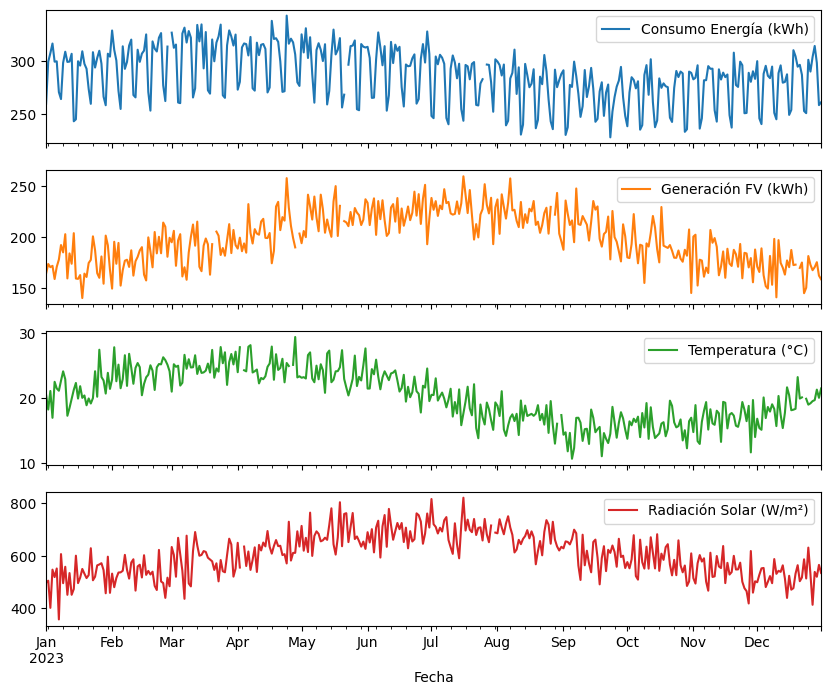

In [3]:
# Visualizar las variables clave
df.plot(subplots=True, figsize=(10, 8))
plt.show()

---

## 2. Preprocesamiento  
- **Rellenar valores nulos**  
- **Normalizar datos** para mejorar la detección  

In [4]:
# Interpolar valores nulos  
df.interpolate(inplace=True)  

# Normalizar datos  
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Convertir datos en formato de ventana temporal  
def create_sequences(data, seq_length=10):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i : i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10  # Ventana de 10 pasos  
X, y = create_sequences(df_scaled, seq_length)


---

## 3. Entrenar Modelo LSTM

In [5]:
# Definir modelo LSTM  
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, df.shape[1])),
    Dropout(0.2),
    LSTM(30, activation='relu', return_sequences=False),
    Dense(df.shape[1])
])

model.compile(optimizer="adam", loss="mse")

# Entrenar el modelo  
model.fit(X, y, epochs=50, batch_size=16, shuffle=True, verbose=1)


/Users/jballesteros/.virtualenvs/ibbi/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.2251
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0574
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0316
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0259
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0224
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0220
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0209
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0224
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0223
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0214
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0218
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0224
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0217
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0226
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0228
Epoc

📌 Explicación:

**Capa LSTM**
 - LSTM con 50 neuronas: Captura patrones temporales en los datos.
 - activation='relu': Usa la función de activación ReLU para mejorar el aprendizaje.
 - return_sequences=True: Devuelve la secuencia completa, necesaria cuando hay más capas LSTM.
 - input_shape=(seq_length, df.shape[1]):
   - seq_length=10 → Cada entrada usa los últimos 10 registros como ventana temporal.
   - df.shape[1] → El número de variables en el dataset (Consumo, Generación FV, Temperatura, etc.).

**Capa Dropout**
- Se usa para evitar sobreajuste, eliminando aleatoriamente el 20% de las conexiones en cada iteración.

**Segunda Capa LSTM**
 - 30 neuronas para extraer información de la secuencia procesada por la primera capa.
 - return_sequences=False porque es la última capa LSTM y queremos solo el resultado final.

**Capa Dropout**
- Se usa para evitar sobreajuste, eliminando aleatoriamente el 20% de las conexiones en cada iteración.

**Capa Densa de Salida**
- Red completamente conectada que devuelve un vector del mismo tamaño que la entrada.
- Permite reconstruir los valores originales y calcular el error para detectar anomalías.

### 3.1. Almacenar modelo

In [6]:
# Guardar modelo en disco
model.save("models/lstm_model.h5")
print("Modelo guardado en disco como 'autoencoder_model.h5'")


Modelo guardado en disco como 'autoencoder_model.h5'


### 3.2 Cargar modelo

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Definir la función de pérdida explícitamente
mse = MeanSquaredError()

# Cargar modelo asegurando que reconoce la función de pérdida
autoencoder_loaded = load_model("models/lstm_model.h5", compile=False)

# Compilar el modelo cargado
autoencoder_loaded.compile(optimizer="adam", loss=mse)

print("Modelo cargado y recompilado exitosamente.")


Modelo cargado y recompilado exitosamente.


---

## 4. Detección de anomalías

In [10]:
# Obtener predicciones del modelo  
predictions = model.predict(X)

# Calcular error de reconstrucción  
mse = np.mean(np.power(y - predictions, 2), axis=1)

# Definir umbral para anomalías (percentil 95)  
threshold = np.percentile(mse, 95)

# Etiquetar anomalías  
df["Anomaly"] = np.append(np.zeros(seq_length), mse > threshold)

# Mostrar conteo de anomalías detectadas  
print(df["Anomaly"].value_counts())


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Anomaly
0.0    347
1.0     18
Name: count, dtype: int64


In [11]:
# Contar el número total de anomalías detectadas
num_anomalies = (df["Anomaly"] == True).sum()
print(f"Número total de anomalías detectadas: {num_anomalies}")


Número total de anomalías detectadas: 18


---

## 4. Visualizar anomalías  

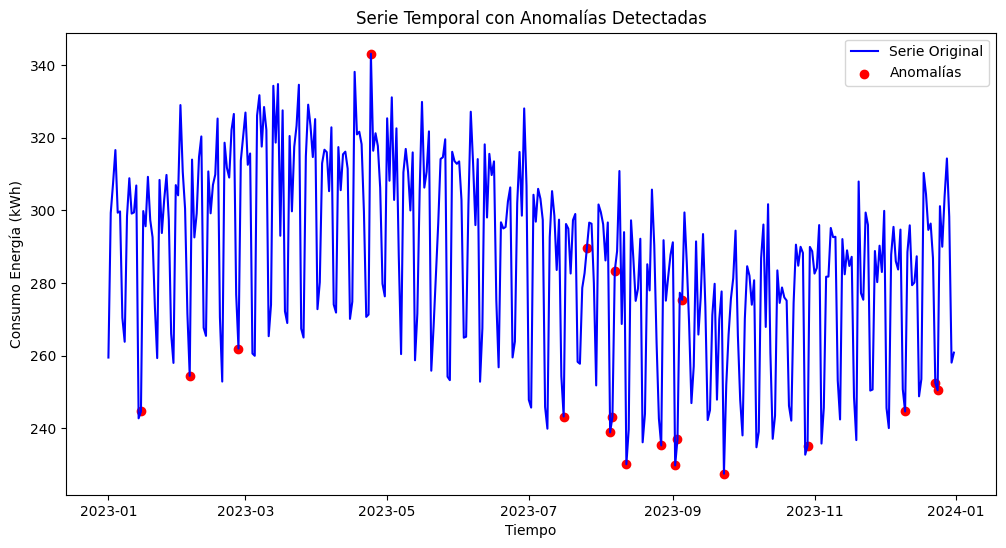

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Consumo Energía (kWh)"], label="Serie Original", color="blue")
plt.scatter(df.index[df["Anomaly"] == 1], df["Consumo Energía (kWh)"][df["Anomaly"] == 1],  
            color='red', label='Anomalías', marker='o')
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía (kWh)")
plt.title("Detección de Anomalías con LSTM")
plt.legend()
plt.show()


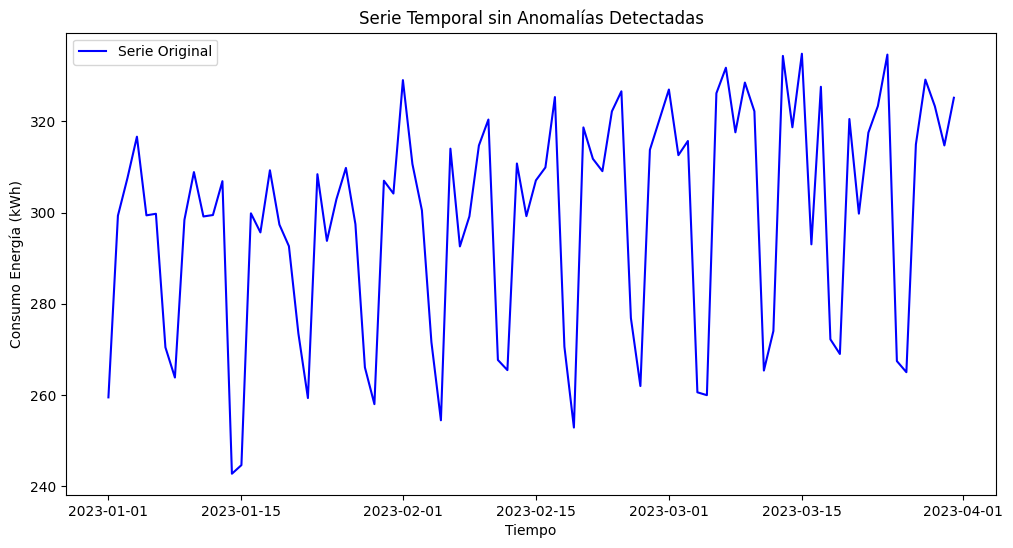

In [20]:
# Aumentamos el zoom en el primer trimestre
plot_df = df[df.index.month < 4]
# 5️⃣ Gráfico de línea con anomalías
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df["Consumo Energía (kWh)"], label="Serie Original", color="blue")
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía (kWh)")
plt.title("Serie Temporal sin Anomalías Detectadas")
plt.legend()
plt.show()

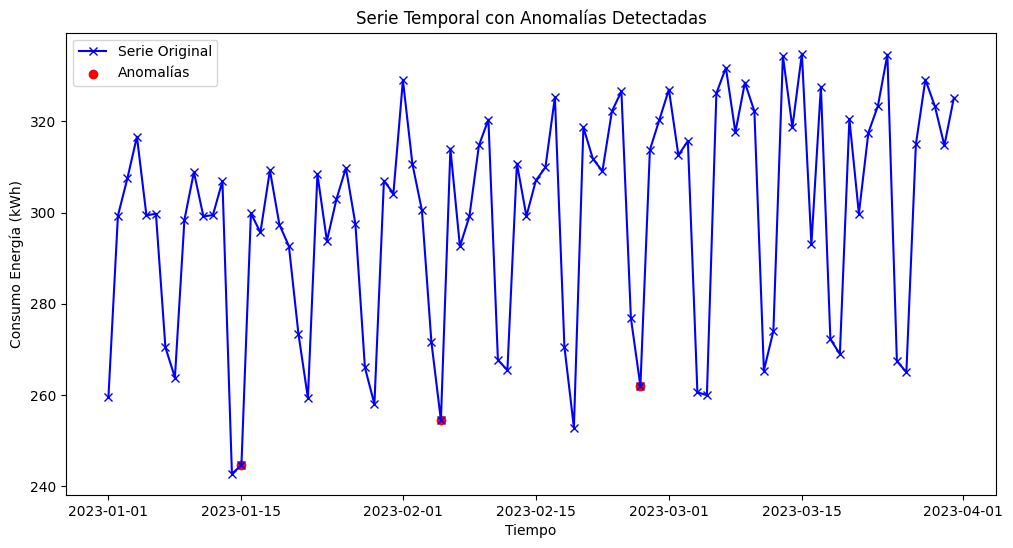

In [22]:
# 5️⃣ Gráfico de línea con anomalías
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df["Consumo Energía (kWh)"], label="Serie Original", color="blue", marker="x")
plt.scatter(plot_df.index[plot_df["Anomaly"]], plot_df["Consumo Energía (kWh)"][plot_df["Anomaly"]],  
            color='red', label='Anomalías', marker='o')
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía (kWh)")
plt.title("Serie Temporal con Anomalías Detectadas")
plt.legend()
plt.show()

---

# **Conclusión**  
- Autoencoder permite detectar anomalías analizando diferencias en la reconstrucción de datos normales.
- Sin necesidad de GPU, este enfoque sigue siendo eficiente con tamaños de batch pequeños y menos neuronas.
- Extensión: Probar diferentes valores de encoding_dim o umbrales de detección.